In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel

import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('Resources/sales.csv')
df.head()

,Date,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales,year,month,day,week_of_year,promotion
0,2010-02-05,1,1,False,9.99,7.99,245,1957.55,2010,2,5,5,1
1,2010-02-12,1,1,True,9.99,7.99,453,3619.47,2010,2,12,6,1
2,2010-02-19,1,1,False,9.99,7.99,409,3267.91,2010,2,19,7,1
3,2010-02-26,1,1,False,9.99,7.99,191,1526.09,2010,2,26,8,1
4,2010-03-05,1,1,False,9.99,9.99,145,1448.55,2010,3,5,9,0


In [3]:
df=df.drop(columns=['Date', 'year', 'day', 'month','weekly_sales'])
df.head()

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,week_of_year,promotion
0,1,1,False,9.99,7.99,245,5,1
1,1,1,True,9.99,7.99,453,6,1
2,1,1,False,9.99,7.99,409,7,1
3,1,1,False,9.99,7.99,191,8,1
4,1,1,False,9.99,9.99,145,9,0


In [4]:
df=df[['Store','Product','week_of_year','Base Price','Price','promotion','Is_Holiday','Weekly_Units_Sold']]
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,1,1,5,9.99,7.99,1,False,245
1,1,1,6,9.99,7.99,1,True,453
2,1,1,7,9.99,7.99,1,False,409
3,1,1,8,9.99,7.99,1,False,191
4,1,1,9,9.99,9.99,0,False,145


In [5]:
df['Temp']='_'
df['Store'] = df['Temp'].str.cat(df['Store'].values.astype(str))
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold,Temp
0,_1,1,5,9.99,7.99,1,False,245,_
1,_1,1,6,9.99,7.99,1,True,453,_
2,_1,1,7,9.99,7.99,1,False,409,_
3,_1,1,8,9.99,7.99,1,False,191,_
4,_1,1,9,9.99,9.99,0,False,145,_


In [6]:
del df['Temp']
df

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,1,5,9.99,7.99,1,False,245
1,_1,1,6,9.99,7.99,1,True,453
2,_1,1,7,9.99,7.99,1,False,409
3,_1,1,8,9.99,7.99,1,False,191
4,_1,1,9,9.99,9.99,0,False,145
...,...,...,...,...,...,...,...,...
3856,_10,3,39,19.99,19.99,0,False,133
3857,_10,3,40,19.99,19.99,0,False,133
3858,_10,3,41,19.99,19.99,0,False,127
3859,_10,3,42,19.99,19.99,0,False,133


In [7]:
df['Temp']='_'
df['Product'] = df['Temp'].str.cat(df['Product'].values.astype(str))
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold,Temp
0,_1,_1,5,9.99,7.99,1,False,245,_
1,_1,_1,6,9.99,7.99,1,True,453,_
2,_1,_1,7,9.99,7.99,1,False,409,_
3,_1,_1,8,9.99,7.99,1,False,191,_
4,_1,_1,9,9.99,9.99,0,False,145,_


In [8]:
del df['Temp']
df

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,5,9.99,7.99,1,False,245
1,_1,_1,6,9.99,7.99,1,True,453
2,_1,_1,7,9.99,7.99,1,False,409
3,_1,_1,8,9.99,7.99,1,False,191
4,_1,_1,9,9.99,9.99,0,False,145
...,...,...,...,...,...,...,...,...
3856,_10,_3,39,19.99,19.99,0,False,133
3857,_10,_3,40,19.99,19.99,0,False,133
3858,_10,_3,41,19.99,19.99,0,False,127
3859,_10,_3,42,19.99,19.99,0,False,133


In [9]:
df['Temp']='_'
df['week_of_year'] = df['Temp'].str.cat(df['week_of_year'].values.astype(str))
del df['Temp']
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,_5,9.99,7.99,1,False,245
1,_1,_1,_6,9.99,7.99,1,True,453
2,_1,_1,_7,9.99,7.99,1,False,409
3,_1,_1,_8,9.99,7.99,1,False,191
4,_1,_1,_9,9.99,9.99,0,False,145


In [10]:
#  LabelEncoding Is_Holiday column
df['Is_Holiday']=LabelEncoder().fit_transform(df['Is_Holiday'])
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,_5,9.99,7.99,1,0,245
1,_1,_1,_6,9.99,7.99,1,1,453
2,_1,_1,_7,9.99,7.99,1,0,409
3,_1,_1,_8,9.99,7.99,1,0,191
4,_1,_1,_9,9.99,9.99,0,0,145


In [11]:
# Create features
X=df.drop(columns=['Weekly_Units_Sold'], axis = 1)

# One Hot Encode. 
X=pd.get_dummies(X)

# Create target. 
y = df['Weekly_Units_Sold']

In [12]:
X

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
0,9.99,7.99,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,9.99,7.99,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,9.99,7.99,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9.99,7.99,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,9.99,9.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,19.99,19.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3857,19.99,19.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3858,19.99,19.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3859,19.99,19.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X.describe()

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
count,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,...,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000
mean,12.554103,11.766084,0.172494,0.069930,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,...,0.013986,0.013986,0.020979,0.013986,0.013986,0.013986,0.020979,0.020979,0.020979,0.020979
std,6.079043,5.976196,0.377858,0.255062,0.314310,0.314310,0.314310,0.314310,0.314310,0.314310,...,0.117448,0.117448,0.143333,0.117448,0.117448,0.117448,0.143333,0.143333,0.143333,0.143333
min,5.990000,4.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.990000,5.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.990000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,19.990000,19.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,21.990000,21.990000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Linear Regression

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Create and train the model
model = LinearRegression().fit(X_train_scaled, y_train)

# Generate predictions
y_pred = model.predict(X_test_scaled)


In [16]:
#  Score Data
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

score = r2_score(y_test, y_pred)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print('---------------------')
print(f"R2 Score: {score}")

Training Score: 0.6942869167782453
Testing Score: 0.6416463956710377
---------------------
R2 Score: 0.6416463956710377


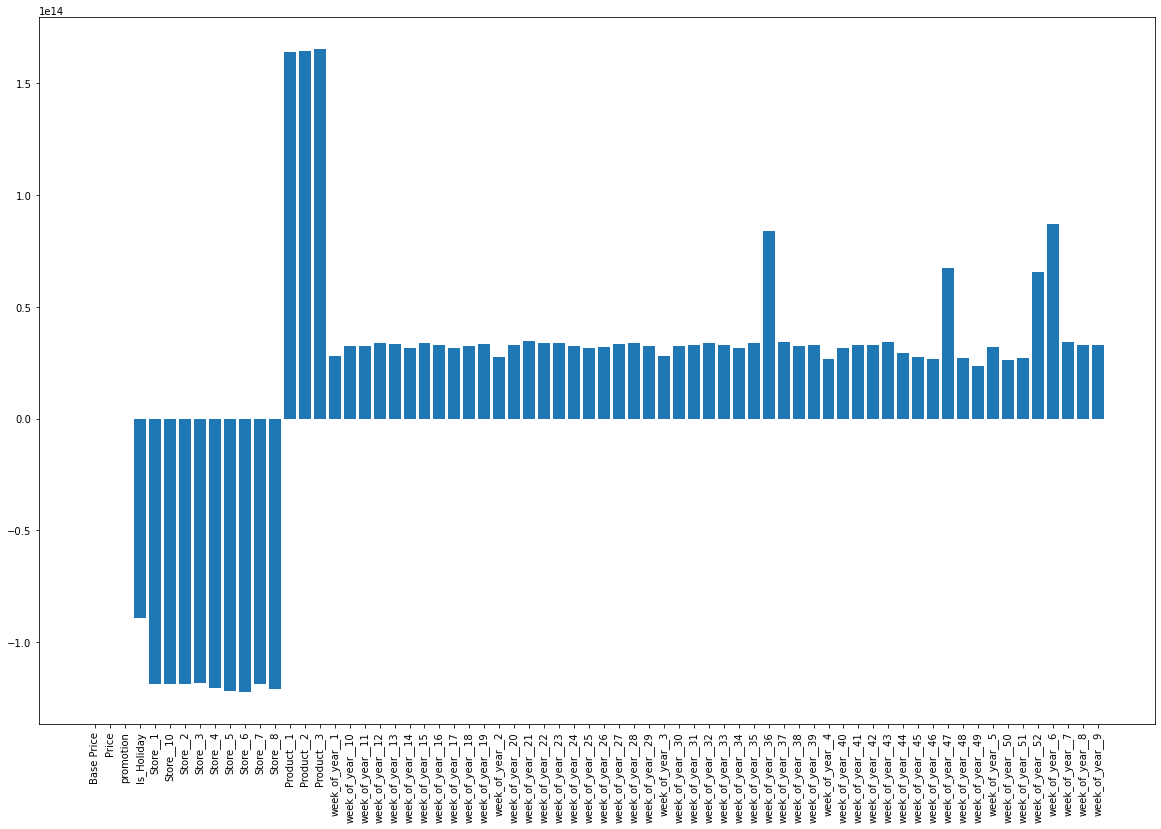

In [17]:
# Visualizing the regression coefficients. 
plt.rcParams["figure.figsize"] = (20,13)
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.coef_,)
plt.show()

## Lasso Regression 

In [18]:
# Create and train the model
model = Lasso(max_iter=10000).fit(X_train_scaled, y_train)

# Generate predictions
y_pred = model.predict(X_test_scaled)


In [19]:
#  Score Data
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

score = r2_score(y_test, y_pred)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print('---------------------')
print(f"R2 Score: {score}")

Training Score: 0.692694529446761
Testing Score: 0.6409196007948497
---------------------
R2 Score: 0.6409196007948497


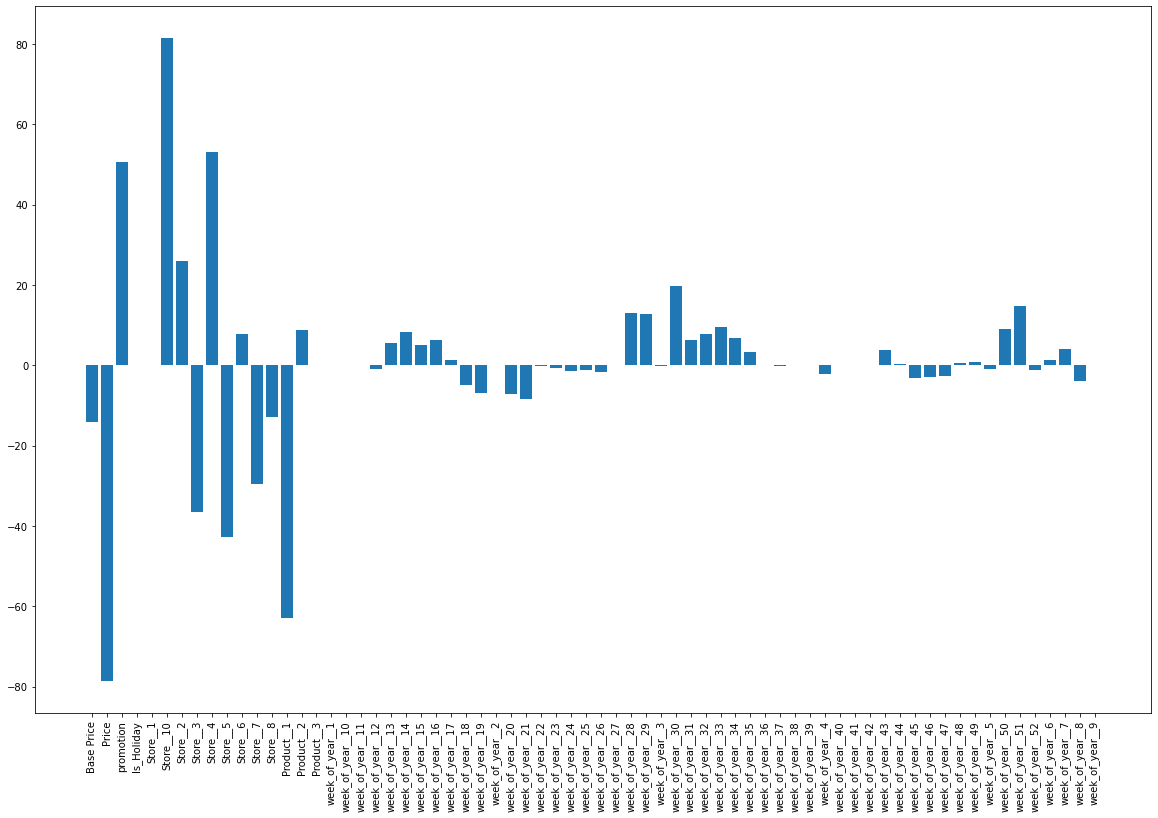

In [20]:
# Visualizing the regression coefficients. 
plt.rcParams["figure.figsize"] = (20,13)
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.coef_)
plt.show()

## Ridge

In [21]:
# Create and train the model
model = Ridge(alpha=100).fit(X_train_scaled, y_train)

# Generate predictions
y_pred = model.predict(X_test_scaled)

In [22]:
#  Score Data
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

score = r2_score(y_test, y_pred)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print('---------------------')
print(f"R2 Score: {score}")

Training Score: 0.6927749062192983
Testing Score: 0.6384478239268325
---------------------
R2 Score: 0.6384478239268325


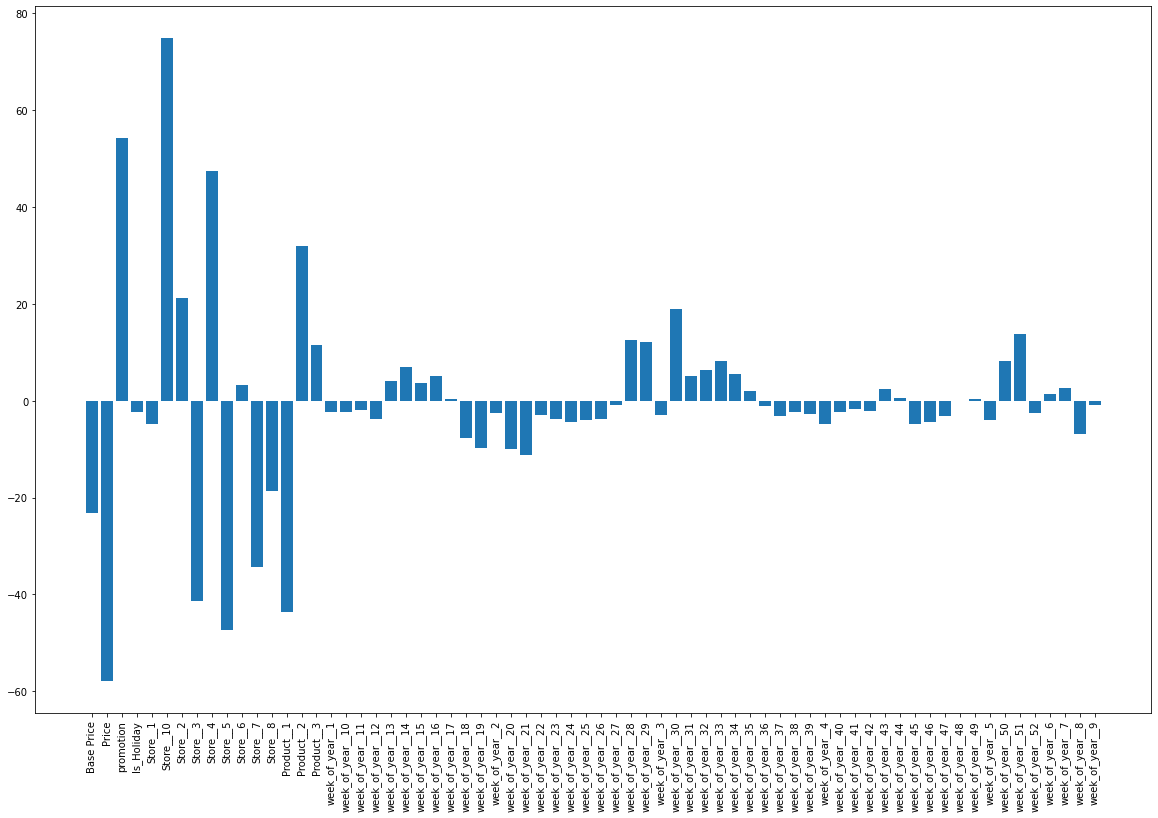

In [23]:
# Visualizing the regression coefficients. 
plt.rcParams["figure.figsize"] = (20,13)
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.coef_)
plt.show()

## ElasticNet

In [25]:
# Create and train the model
model = ElasticNet(alpha=10).fit(X_train_scaled, y_train)

# Generate predictions
y_pred = model.predict(X_test_scaled)

In [26]:
#  Score Data
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

score = r2_score(y_test, y_pred)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print('---------------------')
print(f"R2 Score: {score}")

Training Score: 0.2743888591057969
Testing Score: 0.24072620257201416
---------------------
R2 Score: 0.24072620257201416


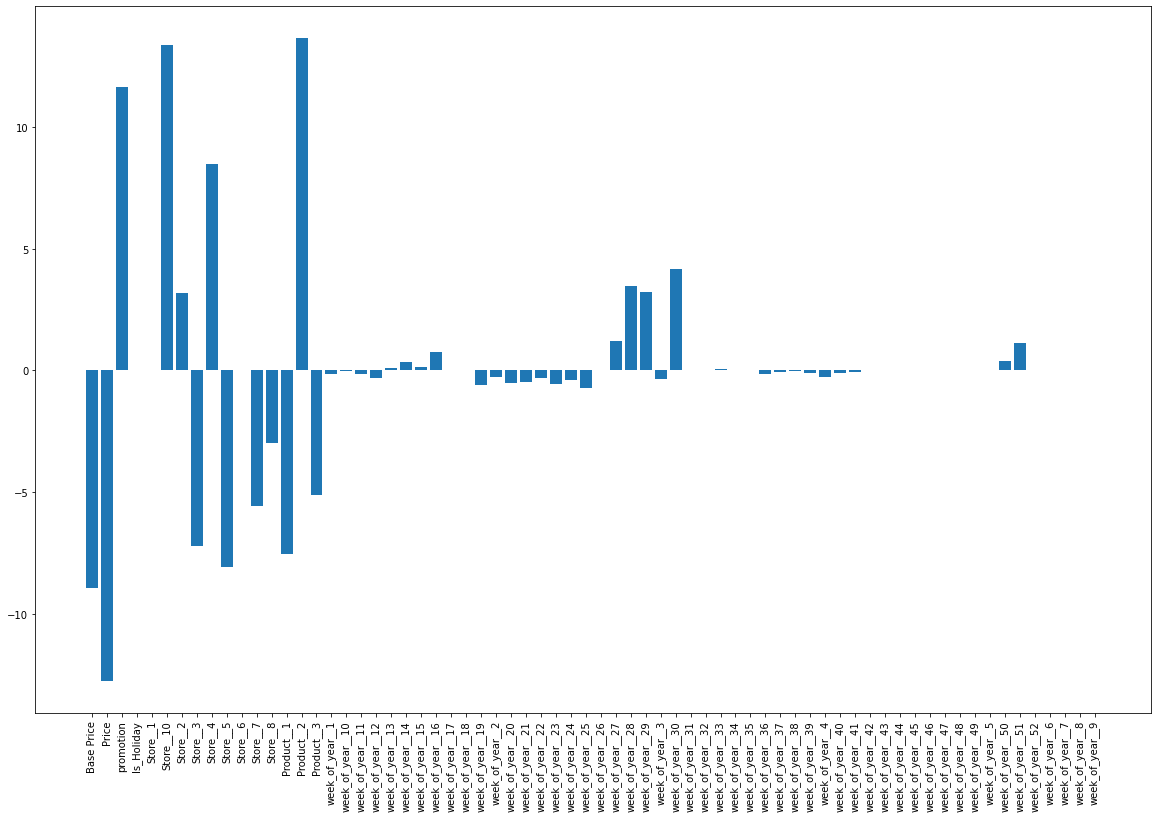

In [27]:
# Visualizing the regression coefficients. 
plt.rcParams["figure.figsize"] = (20,13)
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.coef_)
plt.show()

In [ ]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

In [ ]:
# Select the columns that have a nonzero value from the LASSO regression.
reg = Lasso(max_iter=5000).fit(X_train_scaled, y_train)

In [ ]:
sel = SelectFromModel(reg)
sel.fit(X_train_scaled, y_train)

In [ ]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

In [ ]:
reg = LinearRegression().fit(X_selected_train_scaled, y_train)
reg.score(X_selected_test_scaled, y_test)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
print(reg.coef_)
plt.bar(X.columns, reg.coef_)
plt.show()

In [ ]:
def rmse(X, predictions):
    return np.sqrt(np.mean(np.square(X - predictions)))

In [ ]:
# Create and train the model
model = LinearRegression().fit(X_train, y_train)

# Generate predictions
predictions_test = model.predict(X_test)

# Compute loss to evalute the model
loss = rmse(y_test, predictions_test)
print('Test Loss for LinearRegression:', loss)

# Generate predictions for train set
predictions_train = model.predict(X_train)

# Compute loss on train set to evalute the model
loss = rmse(y_train, predictions_train)
print('Training Loss for LinearRegression:', loss)

In [ ]:
# # Scale the data
# scaler = StandardScaler().fit(X_train)

In [ ]:
# model=LinearRegression()

In [ ]:
# model.fit(X_train, y_train)

In [ ]:
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

In [ ]:
score = model.score(X, y)
print(f"R2 Score: {score}")

In [ ]:
predictions = model.predict(X)
# Plot Residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import numpy as np

In [ ]:
# USE WEIRD MAGICAL FUNCTIONS TO FIT THE CASE DATA TO A SECORD ORDER POLYNOMIAL
poly_model = make_pipeline(PolynomialFeatures(4), LinearRegression())
poly_model.fit(X[:, np.newaxis], y)
Xfit = np.linspace(0, len(X), 1000)
yfit = poly_model.predict(Xfit[:, np.newaxis])

plt.plot(X, y)
plt.plot(Xfit, yfit)
plt.legend(loc="best")

In [ ]:
reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X,y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# Create and train the model
model = LinearRegression().fit(X_train, y_train)